In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report


In [2]:
DATASET_DIR = r"C:\Users\hp\Documents\ForAID_split"

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

print("TensorFlow:", tf.__version__)
print("Dataset path:", DATASET_DIR)


TensorFlow: 2.20.0
Dataset path: C:\Users\hp\Documents\ForAID_split


In [3]:
train_ds = image_dataset_from_directory(
    os.path.join(DATASET_DIR, "train"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED,
    validation_split=0.2,
    subset="training"
)

val_ds = image_dataset_from_directory(
    os.path.join(DATASET_DIR, "train"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED,
    validation_split=0.2,
    subset="validation"
)

test_ds = image_dataset_from_directory(
    os.path.join(DATASET_DIR, "test"),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = train_ds.class_names
print("Classes:", class_names)


Found 1092 files belonging to 2 classes.
Using 874 files for training.
Found 1092 files belonging to 2 classes.
Using 218 files for validation.
Found 100 files belonging to 2 classes.
Classes: ['fire', 'no_fire']


In [4]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000, seed=SEED).prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)
test_ds  = test_ds.cache().prefetch(AUTOTUNE)


In [5]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
])

normalization = layers.Rescaling(1./255)

model_cnn = models.Sequential([
    layers.Input(shape=(*IMG_SIZE, 3)),
    normalization,
    data_augmentation,

    layers.Conv2D(32, 3, activation="relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, activation="relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, activation="relu"),
    layers.MaxPooling2D(),

    layers.Dropout(0.3),              # Reduce overfitting
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(1, activation="sigmoid")  # Binary classification
])

model_cnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model_cnn.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True
    )
]

history_cnn = model_cnn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    callbacks=callbacks
)


Epoch 1/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.6922 - loss: 0.6200 - val_accuracy: 0.8991 - val_loss: 0.3337
Epoch 2/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 27s 977ms/step - accuracy: 0.8787 - loss: 0.3214 - val_accuracy: 0.8899 - val_loss: 0.2650
Epoch 3/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 25s 885ms/step - accuracy: 0.9416 - loss: 0.1472 - val_accuracy: 0.9954 - val_loss: 0.0608
Epoch 4/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 26s 942ms/step - accuracy: 0.9634 - loss: 0.1038 - val_accuracy: 0.9541 - val_loss: 0.1283
Epoch 5/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.9748 - loss: 0.0657 - val_accuracy: 0.9908 - val_loss: 0.0288
Epoch 6/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.9863 - loss: 0.0637 - val_accuracy: 0.9908 - val_loss: 0.0282
Epoch 7/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9760 - loss: 0.0708 - val_accuracy: 0.9954 - val_loss: 0.0306
Epoch 8/25
28/28 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9886 - loss: 0.0345 - val_accuracy: 0.9725 - 

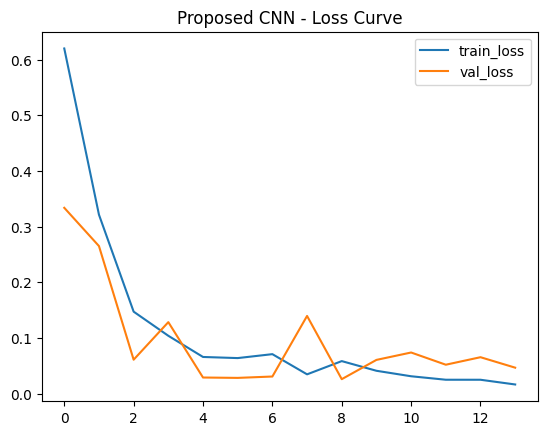

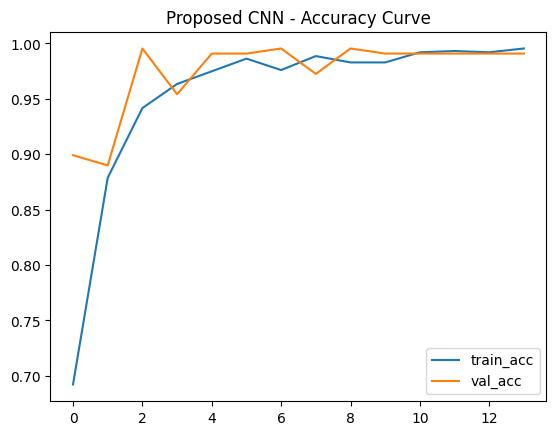

In [7]:
plt.figure()
plt.plot(history_cnn.history["loss"], label="train_loss")
plt.plot(history_cnn.history["val_loss"], label="val_loss")
plt.legend()
plt.title("Proposed CNN - Loss Curve")
plt.show()

plt.figure()
plt.plot(history_cnn.history["accuracy"], label="train_acc")
plt.plot(history_cnn.history["val_accuracy"], label="val_acc")
plt.legend()
plt.title("Proposed CNN - Accuracy Curve")
plt.show()


In [8]:
y_true = np.concatenate([y.numpy() for _, y in test_ds])

y_prob = model_cnn.predict(test_ds).ravel()
y_pred = (y_prob >= 0.5).astype(int)

acc_cnn = accuracy_score(y_true, y_pred)
f1_cnn  = f1_score(y_true, y_pred)

print("CNN Test Accuracy:", acc_cnn)
print("CNN Test F1-score :", f1_cnn)
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=class_names))

cm_cnn = confusion_matrix(y_true, y_pred)
print("Confusion Matrix (CNN):\n", cm_cnn)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 304ms/step
CNN Test Accuracy: 0.99
CNN Test F1-score : 0.9900990099009901

Classification Report:
               precision    recall  f1-score   support

        fire       1.00      0.98      0.99        50
     no_fire       0.98      1.00      0.99        50

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100

Confusion Matrix (CNN):
 [[49  1]
 [ 0 50]]


In [9]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(*IMG_SIZE, 3),
    include_top=False,
    weights="imagenet"
)

# Freeze base model to avoid overfitting
base_model.trainable = False

base_model.summary()


Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [10]:

preprocess_layer = layers.Lambda(
    tf.keras.applications.mobilenet_v2.preprocess_input
)

model_tl = models.Sequential([
    layers.Input(shape=(*IMG_SIZE, 3)),
    preprocess_layer,
    base_model,

    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(1, activation="sigmoid")
])

model_tl.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model_tl.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                 │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [11]:
callbacks_tl = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True
    )
]

history_tl = model_tl.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=callbacks_tl
)


Epoch 1/20


28/28 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.9245 - loss: 0.1530 - val_accuracy: 0.9908 - val_loss: 0.0160
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 24s 855ms/step - accuracy: 0.9989 - loss: 0.0164 - val_accuracy: 1.0000 - val_loss: 0.0048
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 27s 964ms/step - accuracy: 0.9977 - loss: 0.0128 - val_accuracy: 1.0000 - val_loss: 0.0045
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 25s 891ms/step - accuracy: 0.9989 - loss: 0.0078 - val_accuracy: 1.0000 - val_loss: 0.0051
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 24s 880ms/step - accuracy: 0.9989 - loss: 0.0061 - val_accuracy: 1.0000 - val_loss: 0.0030
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 25s 880ms/step - accuracy: 0.9989 - loss: 0.0070 - val_accuracy: 1.0000 - val_loss: 0.0036
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 25s 899ms/step - accuracy: 0.9989 - loss: 0.0046 - val_accuracy: 1.0000 - val_loss: 0.0024
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 27s 957ms/step - accuracy: 0.9989 - loss: 0.0064 - val_accuracy: 1.0000 -

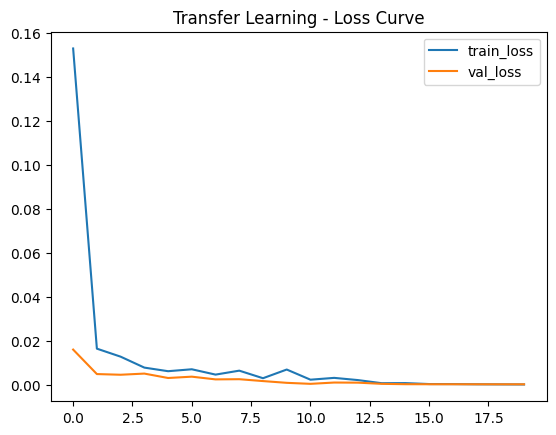

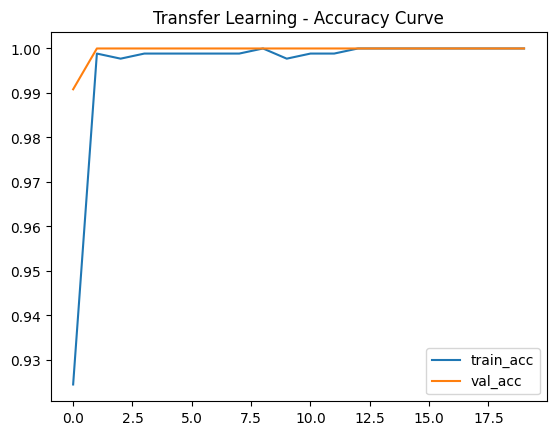

In [12]:
plt.figure()
plt.plot(history_tl.history["loss"], label="train_loss")
plt.plot(history_tl.history["val_loss"], label="val_loss")
plt.legend()
plt.title("Transfer Learning - Loss Curve")
plt.show()

plt.figure()
plt.plot(history_tl.history["accuracy"], label="train_acc")
plt.plot(history_tl.history["val_accuracy"], label="val_acc")
plt.legend()
plt.title("Transfer Learning - Accuracy Curve")
plt.show()


In [13]:
y_prob_tl = model_tl.predict(test_ds).ravel()
y_pred_tl = (y_prob_tl >= 0.5).astype(int)

acc_tl = accuracy_score(y_true, y_pred_tl)
f1_tl  = f1_score(y_true, y_pred_tl)

print("Transfer Learning Test Accuracy:", acc_tl)
print("Transfer Learning Test F1-score :", f1_tl)

print("\nClassification Report (TL):\n",
      classification_report(y_true, y_pred_tl, target_names=class_names))

cm_tl = confusion_matrix(y_true, y_pred_tl)
print("Confusion Matrix (TL):\n", cm_tl)


4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step 
Transfer Learning Test Accuracy: 1.0
Transfer Learning Test F1-score : 1.0

Classification Report (TL):
               precision    recall  f1-score   support

        fire       1.00      1.00      1.00        50
     no_fire       1.00      1.00      1.00        50

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100

Confusion Matrix (TL):
 [[50  0]
 [ 0 50]]


In [14]:
import pandas as pd

results = pd.DataFrame({
    "Model": ["Proposed CNN", "Transfer Learning (MobileNetV2)"],
    "Test Accuracy": [acc_cnn, acc_tl],
    "Test F1-score": [f1_cnn, f1_tl]
})

results

,Model,Test Accuracy,Test F1-score
0,Proposed CNN,0.99,0.990099
1,Transfer Learning (MobileNetV2),1.00,1.000000
